# Feature classification using neural network

Everyting is tested in google colab, some stuff might work differently elswhere. 

We need the stable tf 2.0 because 2.1.0rc1 is buggy when using class_weights. The `%tensorflow_version` magic is only able to switch between tf1.x and tf2.x (which is 2.1.0rc in this case), so we have to force an install. Might not be required on local machine.

In [0]:
!pip install tensorflow==2.0

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, balanced_accuracy_score, accuracy_score
from scipy import interp
import matplotlib.pyplot as plt
import datetime

The features have to be uploaded as two csv files with the test and validation data.

In [3]:
train_d = pd.read_csv("features_train_meta.csv")
test_d = pd.read_csv("features_val_meta.csv")
# extract features and labels
X_train = train_d.iloc[:,1:-9].values
X_test = test_d.iloc[:,1:-9].values
y_train = train_d.iloc[:,-9:].values
y_test = test_d.iloc[:,-9:].values
test_names = test_d.iloc[:,0].values
print("using ", X_train.shape[1], " features")
# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

using  101  features


In [0]:
train_d.head()

,image,harlickFeature1,harlickFeature2,harlickFeature3,harlickFeature4,harlickFeature5,harlickFeature6,harlickFeature7,harlickFeature8,harlickFeature9,harlickFeature10,harlickFeature11,harlickFeature12,harlickFeature13,HueMoment1,HueMoment2,HueMoment3,HueMoment4,HueMoment5,HueMoment6,HueMoment7,m00,m10,m01,m20,m11,m02,m30,m21,m12,m03,mu20,mu11,mu02,mu30,mu21,mu12,mu03,nu20,nu11,...,PCAFeature1,PCAFeature2,PCAFeature3,PCAFeature4,PCAFeature5,PCAFeature6,PCAFeature7,PCAFeature8,PCAFeature9,PCAFeature10,PCAFeature11,PCAFeature12,PCAFeature13,PCAFeature14,PCAFeature15,PCAFeature16,PCAFeature17,PCAFeature18,PCAFeature19,PCAFeature20,female,male,anterior torso,head/neck,lateral torso,lower extremity,oral/genital,palms/soles,posterior torso,upper extremity,age_approx,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0026624,0.016119,2287.502537,0.524977,2458.930917,0.241657,296.398694,7548.221130,5.668937,6.603831,0.000799,3.914101,-0.684566,0.999327,0.000989,8.210383e-08,6.755138e-14,9.700040e-13,-2.480527e-25,-2.343763e-16,1.108848e-26,55007325,16521787110,11950647930,6891986645550,3592989539790,3658933081410,3.223394e+15,1.505743e+15,1.100017e+15,1.271529e+15,1.929567e+12,3.539209e+09,1.062588e+12,-5.770559e+12,6.294346e+12,-5.035911e+11,1.489877e+13,0.000638,0.000001,...,0.748876,0.055082,0.020956,0.014901,0.011500,0.010559,0.009817,0.009224,0.007323,0.006686,0.006180,0.005902,0.005562,0.004929,0.004427,0.004352,0.003706,0.003272,0.003210,0.003015,0,1,0,0,0,1,0,0,0,0,60,0,1,0,0,0,0,0,0,0
1,ISIC_0032373,0.018530,458.740751,0.750321,908.216756,0.215874,316.325758,3174.126272,5.573653,6.563574,0.001038,3.726414,-0.645230,0.998748,0.001011,8.465606e-08,1.807448e-14,2.622682e-13,1.735800e-27,7.143545e-17,-1.797362e-26,53911845,16151296080,12169244640,6728348906430,3607069796505,3794411929920,3.139477e+15,1.495846e+15,1.116930e+15,1.327667e+15,1.889628e+12,-3.867954e+10,1.047511e+12,-8.466003e+12,2.655616e+11,-2.365304e+12,-1.724130e+12,0.000650,-0.000013,...,0.606653,0.084282,0.034912,0.031431,0.016904,0.015824,0.013503,0.013062,0.012641,0.011440,0.009729,0.008304,0.007272,0.006655,0.006058,0.005686,0.005270,0.004777,0.004206,0.004060,1,0,1,0,0,0,0,0,0,0,70,0,0,0,0,1,0,0,0,0
2,ISIC_0012356_downsampled,0.017356,1572.277036,0.332153,1241.434451,0.250874,288.620171,3393.460769,5.446578,6.381588,0.001108,3.772383,-0.700610,0.999341,0.001386,5.772900e-07,6.915766e-10,2.152052e-10,6.363499e-20,1.208002e-13,-5.332386e-20,100684710,61080325950,41217426585,47351816452260,22974466262385,20625335318835,3.949508e+16,1.716037e+16,1.108914e+16,1.113913e+16,1.029747e+13,-2.030064e+12,3.752105e+12,-1.724786e+15,2.389684e+14,2.388903e+14,-3.762934e+14,0.001016,-0.000200,...,0.533187,0.095528,0.054198,0.039368,0.028906,0.019388,0.014862,0.013906,0.011302,0.010343,0.008629,0.007913,0.007417,0.006551,0.006381,0.005970,0.004961,0.004738,0.004302,0.004103,1,0,0,0,0,0,0,0,0,0,70,1,0,0,0,0,0,0,0,0
3,ISIC_0025552,0.018529,2299.458973,0.576312,2775.980933,0.287225,340.248987,8804.464757,5.474723,6.354240,0.000687,3.894430,-0.638863,0.998318,0.000891,6.494596e-08,1.280412e-14,5.521250e-14,-3.846439e-28,-3.453617e-18,-1.416729e-27,59619510,17816958120,13319591970,7361514773940,3969106095975,4107188712000,3.420978e+15,1.639680e+15,1.222822e+15,1.426339e+15,2.037016e+12,-1.137969e+10,1.131459e+12,3.528306e+12,1.845353e+12,4.964480e+11,3.193540e+12,0.000573,-0.000003,...,0.872185,0.091444,0.009521,0.006553,0.002128,0.001793,0.001419,0.000887,0.000783,0.000610,0.000532,0.000501,0.000403,0.000372,0.000333,0.000301,0.000276,0.000260,0.000220,0.000212,0,1,0,0,0,0,0,0,0,0,50,0,1,0,0,0,0,0,0,0
4,ISIC_0010238,0.023923,188.999448,0.901246,954.925187,0.350575,273.798774,3630.701302,5.184988,6.009415,0.001435,3.460602,-0.670007,0.998295,0.000970,1.189252e-07,5.920668e-11,6.319981e-11,1.622656e-21,5.870292e-15,-3.508952e-21,135204315,78558685125,57745141425,57041491821705,31673555679360,30996501143985,4.478276e+16,2.210278e+16,1.641023e+16,1.817792e+16,1.139600e+13,-1.878498e+12,6.333

The format of the network was found by testing of different combinations.

In [0]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(125, activation='relu', input_shape=(X_train.shape[1],)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(170, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(125, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(9, activation='softmax')])


In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['CategoricalAccuracy'])

We use class weights again to handle the imbalanced dataset.

In [0]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

Using early stopping sometimes gives worse performance so we don't use it here.

In [56]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model.fit(X_train, y_train, 
          epochs=60, 
          class_weight=d_class_weights, 
          #callbacks=[callback],
          validation_data=(X_test, y_test)
          )

Train on 22797 samples, validate on 2534 samples
Epoch 1/60
22797/22797 [==============================] - 3s 146us/sample - loss: 1.8169 - CategoricalAccuracy: 0.3511 - val_loss: 1.5567 - val_CategoricalAccuracy: 0.3007
Epoch 2/60
22797/22797 [==============================] - 2s 107us/sample - loss: 1.5997 - CategoricalAccuracy: 0.3994 - val_loss: 1.5390 - val_CategoricalAccuracy: 0.4495
Epoch 3/60
22797/22797 [==============================] - 2s 108us/sample - loss: 1.4939 - CategoricalAccuracy: 0.4171 - val_loss: 1.4127 - val_CategoricalAccuracy: 0.4957
Epoch 4/60
22797/22797 [==============================] - 2s 109us/sample - loss: 1.4430 - CategoricalAccuracy: 0.4351 - val_loss: 1.4150 - val_CategoricalAccuracy: 0.4850
Epoch 5/60
22797/22797 [==============================] - 2s 108us/sample - loss: 1.3759 - CategoricalAccuracy: 0.4511 - val_loss: 1.3636 - val_CategoricalAccuracy: 0.4325
Epoch 6/60
22797/22797 [==============================] - 2s 109us/sample - loss: 1.3167 - 

Now we can do the same evaluation as with sklearn. 

In [0]:
y_pred = model.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1)

average area under curve
0.6790403281393148


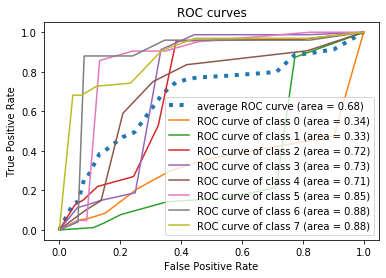

In [59]:
n_classes=8 
fpr = [None]*n_classes  
tpr = [None]*n_classes
roc_auc = [None]*n_classes

for i in range(n_classes):
    fpr[i], tpr[i], __ = roc_curve(y_test_int, y_pred_int, i)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("average area under curve")
print(np.average(roc_auc))

# compute average roc curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
roc_auc_mean = auc(all_fpr, mean_tpr)

# plot the curves
plt.plot(all_fpr, mean_tpr, label='average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc_mean), linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
        ''.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()

In [60]:
confusion_matrix(y_test_int, y_pred_int)

array([[243,  54,  27,  42,  57,  12,   4,  23],
       [163, 844,  69,  24,  84,  55,  29,  15],
       [ 12,   3, 146,  88,  17,  23,   9,  43],
       [  1,   0,   6,  58,   3,   2,   1,   9],
       [ 24,  18,  22,  41, 113,  12,   8,  18],
       [  0,   1,   1,   0,   1,  17,   0,   1],
       [  1,   0,   0,   2,   0,   0,  21,   1],
       [  2,   0,   4,  11,   1,   3,   0,  45]])

In [61]:
print(classification_report(y_test_int, y_pred_int))
print(balanced_accuracy_score(y_test_int, y_pred_int))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54       462
           1       0.92      0.66      0.77      1283
           2       0.53      0.43      0.47       341
           3       0.22      0.72      0.34        80
           4       0.41      0.44      0.42       256
           5       0.14      0.81      0.23        21
           6       0.29      0.84      0.43        25
           7       0.29      0.68      0.41        66

    accuracy                           0.59      2534
   macro avg       0.42      0.64      0.45      2534
weighted avg       0.70      0.59      0.62      2534

0.6387134954267626


In [0]:
test_names=test_names.reshape(-1,1) 
table = np.concatenate((test_names, y_pred), axis=1)
# save with unique filename
d = datetime.datetime.now().strftime("%y-%m-%d_%H-%M-%S")
np.savetxt("classification_"+d+".csv", table, fmt='%s, %.18e, %.18e, %.18e, %.18e, %.18e, %.18e, %.18e, %.18e, %.18e',
            delimiter=",", header="image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK", comments="")
print("file was saved")